## Importing Libraries

In [9]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Simulating Post Office

In [2]:
# Simulating Post Office
def postOffice(env, workers, regular_probability, arrival_rate, processing_rate, T):

    # Creating Workers and queues to handle packages
    workers = simpy.Resource(env, capacity=workers)
    regular_queue = simpy.Store(env)
    priority_queue = simpy.Store(env)

    # Function to process the packages in the queues
    def package_processing(env, package_type):
        with workers.request() as request:
            yield request

            # Updating time when all the workers are busy
            nonlocal last_update, all_busy_time
            current_time = env.now
            if(workers.count == workers.capacity):
                all_busy_time = all_busy_time + (current_time - last_update)
            last_update = current_time

            # package processing
            yield env.timeout(np.random.exponential(1 / processing_rate))
            next_package_type = None
            if(len(priority_queue.items) > 0):
                next_package_type = "priority"
                yield priority_queue.get()
            elif(len(regular_queue.items) > 0):
                next_package_type = "regular"
                yield regular_queue.get()
            
            if(next_package_type is not None):
                env.process(package_processing(env, next_package_type))
    
    
    # Function to handle incoming packages
    def package_arrival(env):
        while True:
            # New package arrival
            yield env.timeout(np.random.exponential(1 / arrival_rate))
            package_type = "regular" if np.random.choice([0.9, 0.1], 1, p=[0.9, 0.1])[0] == regular_probability else "priority"

            # Place packages into queue
            if(package_type == "priority"):
                priority_queue.put(package_type)
            else:
                regular_queue.put(package_type)

            # Process priority packages before regular packages
            if(workers.count < workers.capacity):
                if(len(priority_queue.items) > 0):
                    yield priority_queue.get()
                    env.process(package_processing(env, "priority"))
                else:
                    yield regular_queue.get()
                    env.process(package_processing(env, "regular"))
    
    # Tracking total time all workers were busy
    all_busy_time = 0
    last_update = 0
    
    # Main Simulation run
    env.process(package_arrival(env))
    env.run(until=T)

    # Returning the proportion of time when all the workers were busy
    return all_busy_time / T

## Results

In [3]:
# Simulation Parameters
workers = 9  #Number of workers in the post office
regular_probability = 0.9  #Probability of receiving regular package
arrival_rate = 4  #Packages are arriving at a Poisson process rate of lambda = 4
processing_rate = 0.5  #Packages are processed at an exponential rate of mu = 2
T = 2000  #Total Simulation run time 
number_of_runs = 100  #Number of times running the simulation

# Collecting Results
results = []
for i in range(0, number_of_runs):
    results.append(postOffice(simpy.Environment(), workers, regular_probability, arrival_rate, processing_rate, T))

In [4]:
# Calculating results and confidence interval
max = np.max(results)
min = np.min(results)
mean = np.mean(results)
stddev = np.std(results)
lower, upper = mean - (1.96 * (stddev / np.sqrt(len(results)))), mean + (1.96 * (stddev / np.sqrt(len(results))))

print(f"Max Proportion of Time All Workers are Busy: {max}")
print(f"Mean Proportion of Time All Workers are Busy: {mean}")
print(f"Min Proportion of Time All Workers are Busy: {min}")
print(f"95% Confidence Interval: [{lower}, {upper}]")

Max Proportion of Time All Workers are Busy: 0.811026184265119
Mean Proportion of Time All Workers are Busy: 0.6620354414217118
Min Proportion of Time All Workers are Busy: 0.5636412305766644
95% Confidence Interval: [0.6544723898222953, 0.6695984930211283]


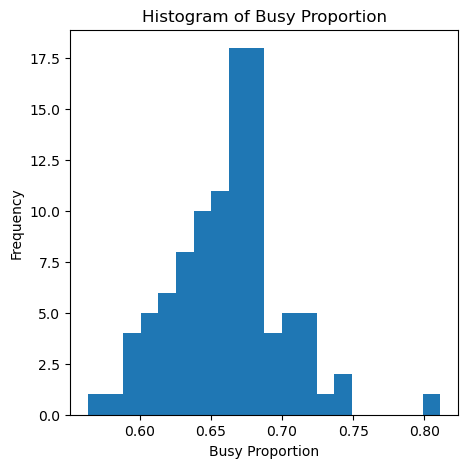

In [5]:
plt.figure(figsize=(5, 5))
plt.hist(results, bins=20)
plt.title("Histogram of Busy Proportion")
plt.xlabel("Busy Proportion")
plt.ylabel("Frequency")
plt.show()

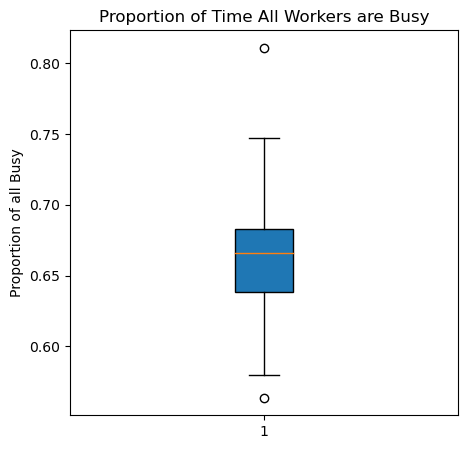

In [7]:
plt.figure(figsize=(5, 5))
plt.boxplot(results, patch_artist=True)
plt.title("Proportion of Time All Workers are Busy")
plt.ylabel("Proportion of all Busy")
plt.show()

In [11]:
df = pd.DataFrame(columns=["workers", "mean"])

for i in range(1, 16):
    workers = i
    regular_probability = 0.9
    arrival_rate = 4
    processing_rate = 0.5
    T = 2000
    number_of_runs = 50

    results = []
    for i in range(0, number_of_runs):
        results.append(postOffice(simpy.Environment(), workers, regular_probability, arrival_rate, processing_rate, T))
    
    df = df._append({"workers": workers, "mean": np.mean(results)}, ignore_index=True)
df

,workers,mean
0,1.0,0.998690
1,2.0,0.999426
2,3.0,0.999378
3,4.0,0.999017
4,5.0,0.998814
5,6.0,0.998378
6,7.0,0.996353
7,8.0,0.961336
8,9.0,0.671707
9,10.0,0.429491


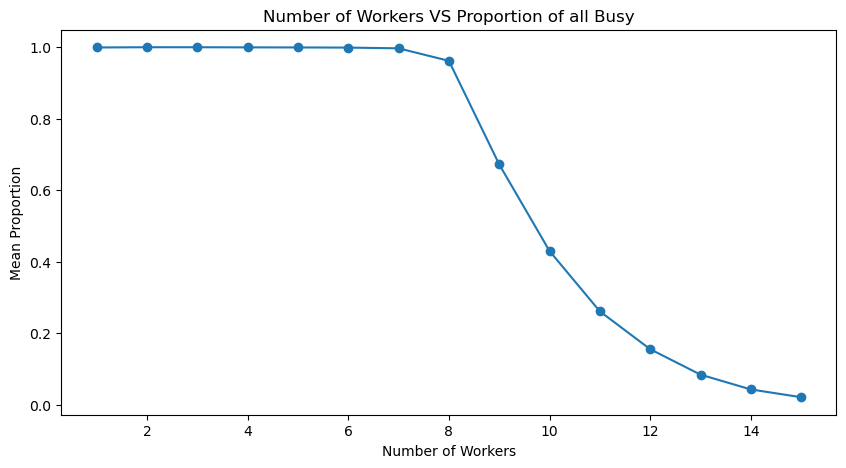

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df["workers"], df["mean"], marker="o")
plt.title("Number of Workers VS Proportion of all Busy")
plt.xlabel("Number of Workers")
plt.ylabel("Mean Proportion")
plt.show()

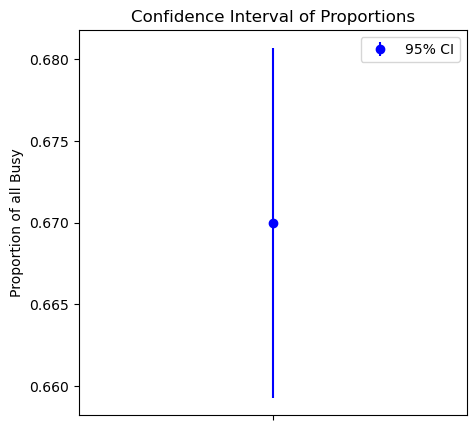

In [19]:
plt.figure(figsize=(5, 5))
plt.errorbar(x=[""], y=[mean], yerr=[1.96 * (stddev / np.sqrt(len(results)))], fmt="o", color="blue", label="95% CI")
plt.title("Confidence Interval of Proportions")
plt.ylabel("Proportion of all Busy")
plt.legend()
plt.show()